<a href="https://colab.research.google.com/github/Seenuprime/Deep-Learning/blob/main/CV_Convolutional_NN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction to Convolutional Neural Network and Computer Vision with Tensorflow

Computer vision is the practice of writting algorithms which can discover patterns in visual data. such as cameras of self-driving cars recognizing the object in front.

**Getting the data**

In [1]:
import zipfile

!wget https://storage.googleapis.com/ztm_tf_course/food_vision/pizza_steak.zip

## Unizip downloaded file
zip_ref = zipfile.ZipFile('pizza_steak.zip')
zip_ref.extractall()
zip_ref.close()

--2024-04-28 06:45:17--  https://storage.googleapis.com/ztm_tf_course/food_vision/pizza_steak.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.141.207, 142.251.2.207, 2607:f8b0:4023:c0d::cf, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.141.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 109540975 (104M) [application/zip]
Saving to: ‘pizza_steak.zip’

pizza_steak.zip     100%[===================>] 104.47M   157MB/s    in 0.7s    

2024-04-28 06:45:18 (157 MB/s) - ‘pizza_steak.zip’ saved [109540975/109540975]



We are using food 101 data from kaggle

In [2]:
!ls pizza_steak/train/pizza

1008104.jpg  1572608.jpg  2097315.jpg  2572958.jpg  3084957.jpg  3693710.jpg  668944.jpg
1008144.jpg  1573562.jpg  2098014.jpg  2574896.jpg  3102271.jpg  3699992.jpg  670201.jpg
1008844.jpg  1576248.jpg  2104569.jpg  2576168.jpg  3105724.jpg  3702863.jpg  674188.jpg
1008941.jpg  1577871.jpg  2110257.jpg  2577373.jpg  3109486.jpg  3703769.jpg  676432.jpg
1011404.jpg  1584379.jpg  2112757.jpg  2577377.jpg  312479.jpg	 3704879.jpg  682201.jpg
102037.jpg   1593665.jpg  2121603.jpg  2581276.jpg  3128495.jpg  3705479.jpg  68684.jpg
1026922.jpg  1593835.jpg  2126352.jpg  2584745.jpg  3148119.jpg  370643.jpg   698251.jpg
1029698.jpg  1600705.jpg  2126709.jpg  2587918.jpg  3164761.jpg  3712344.jpg  702165.jpg
1033251.jpg  1608000.jpg  2135635.jpg  2587921.jpg  3168266.jpg  3713343.jpg  704161.jpg
1035854.jpg  1617418.jpg  2137341.jpg  259449.jpg   3170114.jpg  372275.jpg   709273.jpg
1038357.jpg  1620560.jpg  2142812.jpg  2602611.jpg  3173779.jpg  3742272.jpg  709947.jpg
1040878.jpg  1620761.jp

In [3]:
## Finding out how many images are there in the file
import os
num_images_train_pizza = len(os.listdir('pizza_steak/train/pizza'))
num_images_train_pizza

750

To visualize our images, first get the class names programmatically

In [4]:
import pathlib
import numpy as np

data_dir = pathlib.Path('pizza_steak/train')
class_names = np.array(sorted([item.name for item in data_dir.glob('*')])) # Creates a list of class names from the subdirectory in the training folder
print(class_names)

['pizza' 'steak']


In [5]:
## Visualizing our images
import matplotlib.pyplot as plt
import matplotlib.image as mping
import random

def view_rand_images(target_dir, target_class):
  target_folder = target_dir +'/'+  target_class

  # getting the random image path
  random_image = random.sample(os.listdir(target_folder), 1)
  print(">", random_image)

  ## reading the image and ploting it
  img = mping.imread(target_folder +'/'+ random_image[0])
  plt.imshow(img)
  plt.title(target_class)
  plt.axis(False)

  print(f"Image shape: {img.shape}")
  return img

> ['3790235.jpg']
Image shape: (512, 384, 3)


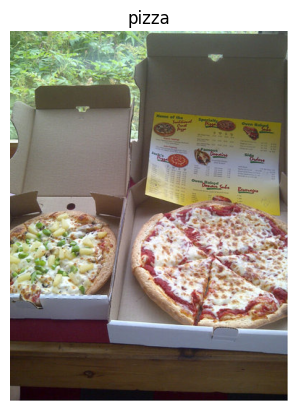

In [6]:
rand_image = view_rand_images('pizza_steak/train', 'pizza')

In [7]:
print(rand_image)

[[[119 140  84]
  [122 145  91]
  [116 145  89]
  ...
  [ 81  87  83]
  [ 73  79  75]
  [172 181 176]]

 [[101 121  68]
  [105 130  75]
  [104 133  77]
  ...
  [ 82  88  84]
  [ 75  81  77]
  [179 185 181]]

 [[ 98 121  69]
  [112 139  86]
  [120 149  93]
  ...
  [ 81  87  83]
  [ 73  80  73]
  [176 183 176]]

 ...

 [[ 93  82  80]
  [ 96  85  83]
  [ 97  87  85]
  ...
  [  4   3   8]
  [  2   2   4]
  [150 150 152]]

 [[ 71  61  62]
  [ 73  65  63]
  [ 73  68  65]
  ...
  [  0   0   2]
  [  8  10   9]
  [132 134 133]]

 [[180 169 173]
  [182 173 174]
  [181 177 176]
  ...
  [148 149 151]
  [134 136 135]
  [197 199 196]]]


In [8]:
# print(rand_image)(224, 224, 3) --> 255 Height 255 Width 3 color channels.
## each values in the array elements represents the color channels of every pixel
## ex: [ 58  43  20] one pixel with color 58 red, 43 green, 20 blue

Machine learning and neural network prefers the values with between 0 and 1. (normalizing)

## Building Convolutional Neural Network

* Loading the images
* Preprocessing the images (image values)
* Building a CNN
* Compiling the CNN
* fitting the CNN

**Using google's T4 GPU**

In [9]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

tf.random.set_seed(42)

## Preprocessing the data (scaling/normalize)
train_datagen = ImageDataGenerator(rescale=1./255)
valid_datagen = ImageDataGenerator(rescale=1./255)

## Setup paths to our directory
train_dir = '/content/pizza_steak/train'
test_dir = '/content/pizza_steak/test'

## Import data from directories and turn it into batches
train_data = train_datagen.flow_from_directory(directory = train_dir,
                                               batch_size = 32,
                                               target_size = (224, 224),
                                               class_mode = 'binary',
                                               seed = 42)

valid_data = valid_datagen.flow_from_directory(directory = test_dir,
                                               batch_size = 32,
                                               target_size = (224, 224),
                                               class_mode = 'binary',
                                               seed = 42)


## Building the CNN (same as the Tiny VGG on CNN explainer website)
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(filters=10,
                           kernel_size=3,
                           activation='relu',
                           input_shape=(224, 224, 3)), ## Input layer
    tf.keras.layers.Conv2D(10, 3, activation='relu'),

    tf.keras.layers.MaxPool2D(pool_size=2,
                              padding='valid'),

    tf.keras.layers.Conv2D(10, 3, activation='relu'),
    tf.keras.layers.Conv2D(10, 3, activation='relu'),

    tf.keras.layers.MaxPool2D(pool_size=2,
                              padding='valid'),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

## Compile our CNN
model.compile(
    loss='binary_crossentropy',
    optimizer = 'Adam',
    metrics = ['accuracy']
)

## fit
model.fit(train_data, ## the flow_from_directory() will automatically create the labels
          epochs = 5,
          steps_per_epoch = len(train_data),
          validation_data = valid_data,
          validation_steps = len(valid_data))

Found 1500 images belonging to 2 classes.
Found 500 images belonging to 2 classes.
Epoch 1/5
47/47 [==============================] - 13s 164ms/step - loss: 0.5714 - accuracy: 0.6927 - val_loss: 0.4018 - val_accuracy: 0.8440
Epoch 2/5
47/47 [==============================] - 6s 122ms/step - loss: 0.4437 - accuracy: 0.7993 - val_loss: 0.3784 - val_accuracy: 0.8580
Epoch 3/5
47/47 [==============================] - 7s 141ms/step - loss: 0.3948 - accuracy: 0.8273 - val_loss: 0.3727 - val_accuracy: 0.8060
Epoch 4/5
47/47 [==============================] - 6s 132ms/step - loss: 0.3582 - accuracy: 0.8500 - val_loss: 0.3403 - val_accuracy: 0.8520
Epoch 5/5
47/47 [==============================] - 6s 123ms/step - loss: 0.3082 - accuracy: 0.8767 - val_loss: 0.3475 - val_accuracy: 0.8600


In [10]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 10)      280       
                                                                 
 conv2d_1 (Conv2D)           (None, 220, 220, 10)      910       
                                                                 
 max_pooling2d (MaxPooling2  (None, 110, 110, 10)      0         
 D)                                                              
                                                                 
 conv2d_2 (Conv2D)           (None, 108, 108, 10)      910       
                                                                 
 conv2d_3 (Conv2D)           (None, 106, 106, 10)      910       
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 53, 53, 10)        0         
 g2D)                                                   

## Understanding the above Deeply

In [11]:
## Defining the directory path
train_dir = '/content/pizza_steak/train'
test_dir = '/content/pizza_steak/test'

Next step is to turn our data into **batchs**.

batch is a small subset of data, Rather look at all the images at one time, a model might look 32 at a time.

* all the images might not fit into the memoryof our processor, so we give model batch by batch.

* Trying to learn the patterns in all the images in one hit could result in the model not being able to learn very well.


In [12]:
## Creating train data test data generators and rescale the data
from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

In [13]:
## Load in our data from our directory and turn them into batches
train_data = train_datagen.flow_from_directory(directory = train_dir, ## target directory
                                               batch_size = 32,
                                               target_size = (224, 224), ## target size (height, width)
                                               class_mode = 'binary', ## type of data you're working with
                                               seed = 42)  ## size of minibatchs to load data into

test_data = valid_datagen.flow_from_directory(directory = test_dir,
                                               batch_size = 32,
                                               target_size = (224, 224),
                                               class_mode = 'binary',
                                               seed = 42)


Found 1500 images belonging to 2 classes.
Found 500 images belonging to 2 classes.


In [14]:
## Get a sample of train data batch
images, labels = train_data.next() # get the next "batch" of the images/labels in train_data
len(images), len(labels)

(32, 32)

In [15]:
## Get the first two images
images[0], images[0].shape

(array([[[0.42352945, 0.43137258, 0.34509805],
         [0.3137255 , 0.32941177, 0.2392157 ],
         [0.26666668, 0.28235295, 0.18431373],
         ...,
         [0.42352945, 0.34509805, 0.3803922 ],
         [0.427451  , 0.34901962, 0.39607847],
         [0.45098042, 0.36862746, 0.427451  ]],
 
        [[0.2901961 , 0.30588236, 0.21568629],
         [0.45882356, 0.47450984, 0.37647063],
         [0.2627451 , 0.28627452, 0.18431373],
         ...,
         [0.39607847, 0.34117648, 0.34117648],
         [0.4156863 , 0.36862746, 0.38431376],
         [0.39607847, 0.34901962, 0.3647059 ]],
 
        [[0.3647059 , 0.40000004, 0.29411766],
         [0.38823533, 0.42352945, 0.31764707],
         [0.30588236, 0.34117648, 0.23529413],
         ...,
         [0.34509805, 0.3254902 , 0.30980393],
         [0.30980393, 0.29803923, 0.2784314 ],
         [0.3372549 , 0.3254902 , 0.30588236]],
 
        ...,
 
        [[0.5137255 , 0.5019608 , 0.54509807],
         [0.52156866, 0.50980395, 0.54509

##Creating CNN

In [16]:
tf.random.set_seed(42)

model_2 = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(filters=10,
                           kernel_size=3,
                           activation='relu',
                           input_shape=(224, 224, 3)), ## Input layer

    tf.keras.layers.Conv2D(10, 3, activation='relu'),
    tf.keras.layers.Conv2D(10, 3, activation='relu'),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

## Compile our CNN
model_2.compile(
    loss='binary_crossentropy',
    optimizer = 'Adam',
    metrics = ['accuracy']
)

## fit
model_2_history = model_2.fit(train_data, ## the flow_from_directory() will automatically create the labels
          epochs = 5,
          steps_per_epoch = len(train_data),
          validation_data = test_data,
          validation_steps = len(test_data))

Epoch 1/5
47/47 [==============================] - 9s 130ms/step - loss: 0.8753 - accuracy: 0.5973 - val_loss: 0.5470 - val_accuracy: 0.7220
Epoch 2/5
47/47 [==============================] - 7s 140ms/step - loss: 0.4654 - accuracy: 0.7773 - val_loss: 0.4767 - val_accuracy: 0.7760
Epoch 3/5
47/47 [==============================] - 6s 126ms/step - loss: 0.3013 - accuracy: 0.8980 - val_loss: 0.4446 - val_accuracy: 0.7920
Epoch 4/5
47/47 [==============================] - 7s 139ms/step - loss: 0.1239 - accuracy: 0.9707 - val_loss: 0.4970 - val_accuracy: 0.8080
Epoch 5/5
47/47 [==============================] - 6s 135ms/step - loss: 0.0363 - accuracy: 0.9933 - val_loss: 0.6025 - val_accuracy: 0.8000


In [17]:
len(train_data), len(test_data)

(47, 16)

In [18]:
model_2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 222, 222, 10)      280       
                                                                 
 conv2d_5 (Conv2D)           (None, 220, 220, 10)      910       
                                                                 
 conv2d_6 (Conv2D)           (None, 218, 218, 10)      910       
                                                                 
 flatten_1 (Flatten)         (None, 475240)            0         
                                                                 
 dense_1 (Dense)             (None, 1)                 475241    
                                                                 
Total params: 477341 (1.82 MB)
Trainable params: 477341 (1.82 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


<Axes: >

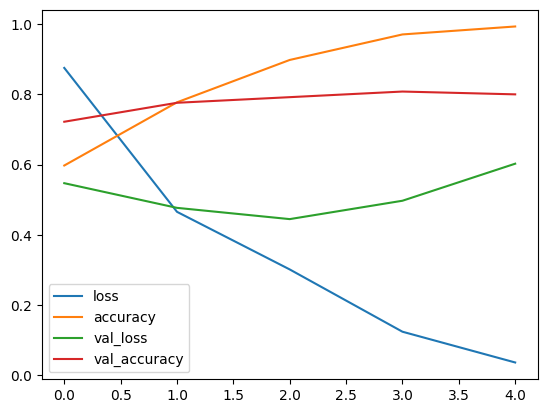

In [19]:
import pandas as pd
pd.DataFrame(model_2_history.history).plot()

**Reduce overfitting:-**
* Add data augmentation
* Add Regulation layers (also know as reduce overfitting) (MaxPool2D)
* Add more Data


In [20]:
## Creating the model (MaxPool2D)
tf.random.set_seed(42)

model_3 = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(filters=10,
                           kernel_size=3,
                           activation='relu',
                           input_shape=(224, 224, 3)), ## Input layer
    tf.keras.layers.MaxPool2D(pool_size=2),

    tf.keras.layers.Conv2D(10, 3, activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size=2),

    tf.keras.layers.Conv2D(10, 3, activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size=2),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model_3.compile(
    loss='binary_crossentropy',
    optimizer = 'Adam',
    metrics = ['accuracy']
)

model_3_history = model_3.fit(train_data, ## the flow_from_directory() will automatically create the labels
          epochs = 5,
          steps_per_epoch = len(train_data),
          validation_data = test_data,
          validation_steps = len(test_data))

Epoch 1/5
47/47 [==============================] - 9s 146ms/step - loss: 0.5716 - accuracy: 0.7073 - val_loss: 0.5192 - val_accuracy: 0.7440
Epoch 2/5
47/47 [==============================] - 5s 117ms/step - loss: 0.4767 - accuracy: 0.7887 - val_loss: 0.3961 - val_accuracy: 0.8460
Epoch 3/5
47/47 [==============================] - 6s 136ms/step - loss: 0.4301 - accuracy: 0.8127 - val_loss: 0.3529 - val_accuracy: 0.8520
Epoch 4/5
47/47 [==============================] - 6s 135ms/step - loss: 0.3967 - accuracy: 0.8293 - val_loss: 0.3562 - val_accuracy: 0.8380
Epoch 5/5
47/47 [==============================] - 5s 115ms/step - loss: 0.3780 - accuracy: 0.8320 - val_loss: 0.3222 - val_accuracy: 0.8840


In [21]:
model_3.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_7 (Conv2D)           (None, 222, 222, 10)      280       
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 111, 111, 10)      0         
 g2D)                                                            
                                                                 
 conv2d_8 (Conv2D)           (None, 109, 109, 10)      910       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 54, 54, 10)        0         
 g2D)                                                            
                                                                 
 conv2d_9 (Conv2D)           (None, 52, 52, 10)        910       
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 26, 26, 10)       

Finding data augmentation

In [22]:
## Create ImageDataGenerator training instance with data augmentation
train_data_augmentation = ImageDataGenerator(rescale=1./255,
                                             rotation_range=0.2,
                                             shear_range=0.2,
                                             zoom_range=0.2,
                                             width_shift_range=0.2,
                                             height_shift_range=0.2,
                                             horizontal_flip=True)

## Creating ImageDataGenerator without data augmentation
train_datagen = ImageDataGenerator(rescale=1./255)

## Creating ImageDataGenerator without data augmentation for taining dataset
test_datagen = ImageDataGenerator(rescale=1./255)

Visualizing Data augmentation

In [23]:
## Import data and augment it from training directory
print("Augmented training data: ")
training_data_augmented = train_data_augmentation.flow_from_directory(train_dir,
                                                                   target_size=(224, 224),
                                                                   batch_size=32,
                                                                   class_mode='binary',
                                                                   shuffle=False) ##only for demonstration purpose

## Creating non-augmented training data batches
print("Non-augmented training data: ")
trainig_data_non_augmented = train_datagen.flow_from_directory(train_dir,
                                                               target_size=(224, 224),
                                                               batch_size=32,
                                                               class_mode='binary',
                                                               shuffle=False)

## Creating non-augmented test data batches
print("Non-augmented test data: ")
test_data_non_augmented = test_datagen.flow_from_directory(test_dir,
                                                           batch_size=32,
                                                           target_size=(224, 224),
                                                           class_mode='binary',
                                                           shuffle=False)


Augmented training data: 
Found 1500 images belonging to 2 classes.
Non-augmented training data: 
Found 1500 images belonging to 2 classes.
Non-augmented test data: 
Found 500 images belonging to 2 classes.


**Note:** Data augmentation only performed on training data. Using `ImageDataGenerator` built-in augmentation parameters our images are left as they are in the directory but are modefied as ther're loaded into the model.

In [24]:
## Visualizing the augmented data
images, labels = trainig_data_non_augmented.next()

augmented_images, augmented_labels = training_data_augmented.next() ##Note labels are not augmented only the data (images)

(-0.5, 223.5, 223.5, -0.5)

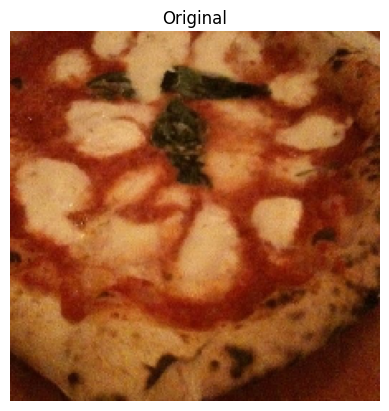

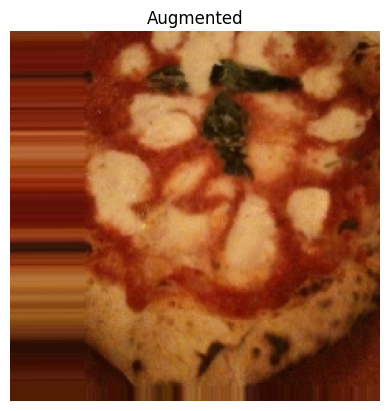

In [25]:
## Showing the Original image and Augmented image
import random

rand_index = random.randint(0, 32) ##Because our batch containes only 32 images

plt.imshow(images[rand_index])
plt.title('Original')
plt.axis(False)
plt.figure()

plt.imshow(augmented_images[rand_index])
plt.title("Augmented")
plt.axis(False)

## Building Model on augmented data

In [26]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPool2D, Activation
from tensorflow.keras import Sequential

In [27]:
model_4 = Sequential([
  Conv2D(10, 3, activation='relu', input_shape=(224, 224, 3)),
  MaxPool2D(pool_size=2), # reduce number of features by half
  Conv2D(10, 3, activation='relu'),
  MaxPool2D(),
  Conv2D(10, 3, activation='relu'),
  MaxPool2D(),
  Flatten(),
  Dense(1, activation='sigmoid')
])

# Compile the model
model_4.compile(loss='binary_crossentropy',
                optimizer=Adam(),
                metrics=['accuracy'])

# Fit the model
history_4 = model_4.fit(training_data_augmented, # changed to augmented training data
                        epochs=5,
                        steps_per_epoch=len(training_data_augmented),
                        validation_data=test_data,
                        validation_steps=len(test_data))


Epoch 1/5
47/47 [==============================] - 23s 447ms/step - loss: 0.7080 - accuracy: 0.4740 - val_loss: 0.6865 - val_accuracy: 0.5000
Epoch 2/5
47/47 [==============================] - 20s 428ms/step - loss: 0.6925 - accuracy: 0.5827 - val_loss: 0.6708 - val_accuracy: 0.7220
Epoch 3/5
47/47 [==============================] - 21s 448ms/step - loss: 0.6777 - accuracy: 0.5767 - val_loss: 0.6234 - val_accuracy: 0.7420
Epoch 4/5
47/47 [==============================] - 21s 442ms/step - loss: 0.6754 - accuracy: 0.6013 - val_loss: 0.6118 - val_accuracy: 0.7460
Epoch 5/5
47/47 [==============================] - 21s 449ms/step - loss: 0.6283 - accuracy: 0.6647 - val_loss: 0.5196 - val_accuracy: 0.7460


In [28]:
model_4.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 222, 222, 10)      280       
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 111, 111, 10)      0         
 g2D)                                                            
                                                                 
 conv2d_11 (Conv2D)          (None, 109, 109, 10)      910       
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 54, 54, 10)        0         
 g2D)                                                            
                                                                 
 conv2d_12 (Conv2D)          (None, 52, 52, 10)        910       
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 26, 26, 10)       

<Axes: >

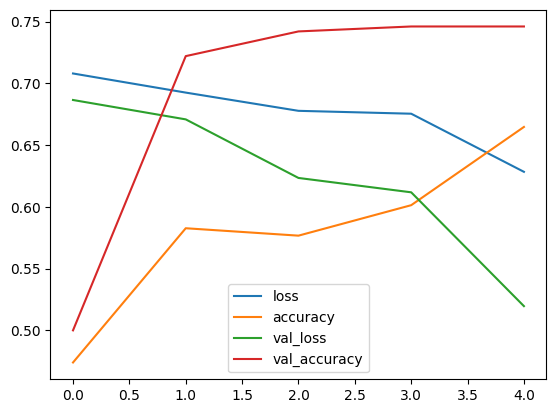

In [29]:
pd.DataFrame(history_4.history).plot()

**Shuffling our training augmented data and train another model**

In [30]:
training_data_augmented_shuffled = train_data_augmentation.flow_from_directory(train_dir,
                                                                               target_size=(224, 224),
                                                                               batch_size=32,
                                                                               class_mode = 'binary',
                                                                               shuffle=True)

Found 1500 images belonging to 2 classes.


In [31]:
model_5 = Sequential([
    Conv2D(filters=10,
           kernel_size=3,
           activation='relu',
           input_shape=(224, 224, 3)),
    MaxPool2D(pool_size=2),
    Conv2D(10, 3, activation='relu'),
    MaxPool2D(pool_size=2),
    Conv2D(10, 3, activation='relu'),
    MaxPool2D(pool_size=2),
    Flatten(),
    Dense(1, activation='sigmoid')
])

model_5.compile(
    loss = 'binary_crossentropy',
    optimizer = Adam(),
    metrics = ['accuracy']
)

history_5 = model_5.fit(training_data_augmented_shuffled,
                        epochs=5,
                        steps_per_epoch = len(training_data_augmented_shuffled),
                        validation_data = test_data,
                        validation_steps = len(test_data))

Epoch 1/5
47/47 [==============================] - 22s 429ms/step - loss: 0.6836 - accuracy: 0.5600 - val_loss: 0.6211 - val_accuracy: 0.6880
Epoch 2/5
47/47 [==============================] - 21s 447ms/step - loss: 0.5964 - accuracy: 0.6707 - val_loss: 0.6449 - val_accuracy: 0.6040
Epoch 3/5
47/47 [==============================] - 21s 446ms/step - loss: 0.5179 - accuracy: 0.7373 - val_loss: 0.4595 - val_accuracy: 0.7920
Epoch 4/5
47/47 [==============================] - 21s 441ms/step - loss: 0.4526 - accuracy: 0.7900 - val_loss: 0.3911 - val_accuracy: 0.8260


In [32]:
model_5.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_13 (Conv2D)          (None, 222, 222, 10)      280       
                                                                 
 max_pooling2d_8 (MaxPoolin  (None, 111, 111, 10)      0         
 g2D)                                                            
                                                                 
 conv2d_14 (Conv2D)          (None, 109, 109, 10)      910       
                                                                 
 max_pooling2d_9 (MaxPoolin  (None, 54, 54, 10)        0         
 g2D)                                                            
                                                                 
 conv2d_15 (Conv2D)          (None, 52, 52, 10)        910       
                                                                 
 max_pooling2d_10 (MaxPooli  (None, 26, 26, 10)       

<Axes: >

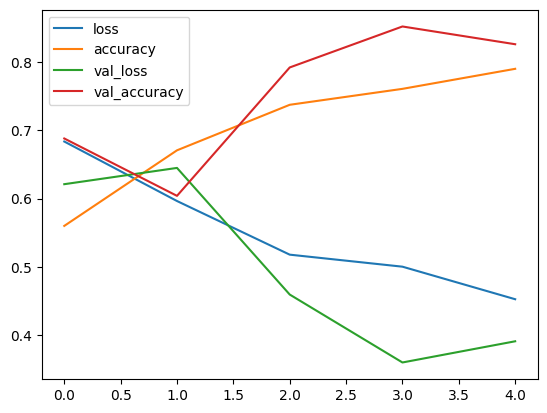

In [33]:
pd.DataFrame(history_5.history).plot()

**Loaing and Predicting single image**

--2024-04-28 06:51:50--  https://as1.ftcdn.net/v2/jpg/05/60/70/82/1000_F_560708240_pMZPOuSfvblWGRoaiZFLT4wiFTzQPwQe.jpg
Resolving as1.ftcdn.net (as1.ftcdn.net)... 151.101.1.167, 151.101.65.167, 151.101.129.167, ...
Connecting to as1.ftcdn.net (as1.ftcdn.net)|151.101.1.167|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 408059 (398K) [image/jpeg]
Saving to: ‘1000_F_560708240_pMZPOuSfvblWGRoaiZFLT4wiFTzQPwQe.jpg’

1000_F_560708240_pM 100%[===================>] 398.50K  --.-KB/s    in 0.02s   

2024-04-28 06:51:51 (18.0 MB/s) - ‘1000_F_560708240_pMZPOuSfvblWGRoaiZFLT4wiFTzQPwQe.jpg’ saved [408059/408059]



(-0.5, 999.5, 666.5, -0.5)

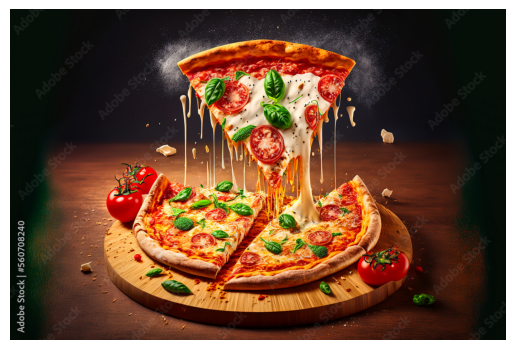

In [34]:
## Getting the image
!wget https://as1.ftcdn.net/v2/jpg/05/60/70/82/1000_F_560708240_pMZPOuSfvblWGRoaiZFLT4wiFTzQPwQe.jpg
own_image = mping.imread('1000_F_560708240_pMZPOuSfvblWGRoaiZFLT4wiFTzQPwQe.jpg')
plt.imshow(own_image)
plt.axis(False)

In [35]:
own_image.shape

(667, 1000, 3)

In [36]:
## Create the function to import the image and resize the image to
def load_image_pre_image(filename, image_shape=224):
    """ Read an image from filename, turn it into tensors and reshape
    it to [image_shape, image_shape, color channel].
    """
    # Read in the image
    img = tf.io.read_file(filename)
    # Decode the image into tensors
    img = tf.image.decode_image(img)
    # Resize the image
    img = tf.image.resize(img, size=[image_shape, image_shape])
    # Rescale the image (get all values between 0 and 1)
    img = img/255.

    return img

In [37]:
!wget https://www.cookingcarnival.com/wp-content/uploads/2019/11/Paneer-Pizza.jpg
filename = 'Paneer-Pizza.jpg'
loaded_image = load_image_pre_image(filename)

--2024-04-28 06:51:51--  https://www.cookingcarnival.com/wp-content/uploads/2019/11/Paneer-Pizza.jpg
Resolving www.cookingcarnival.com (www.cookingcarnival.com)... 104.21.33.84, 172.67.160.128, 2606:4700:3031::ac43:a080, ...
Connecting to www.cookingcarnival.com (www.cookingcarnival.com)|104.21.33.84|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 268187 (262K) [image/jpeg]
Saving to: ‘Paneer-Pizza.jpg’

Paneer-Pizza.jpg    100%[===================>] 261.90K  --.-KB/s    in 0.01s   

2024-04-28 06:51:51 (17.3 MB/s) - ‘Paneer-Pizza.jpg’ saved [268187/268187]



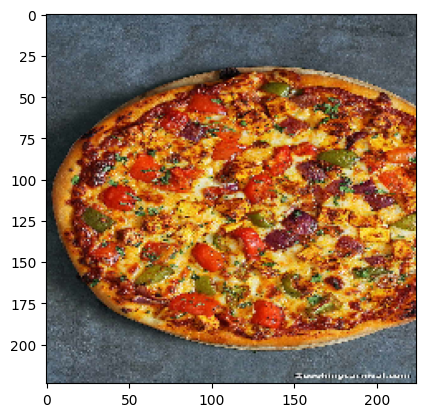

In [38]:
plt.imshow(loaded_image)

In [39]:
predicted = model_5.predict(tf.expand_dims(loaded_image, axis=0))
predicted

1/1 [==============================] - 0s 252ms/step


array([[0.47306925]], dtype=float32)

if array < 0.5 belongs to class 0 pizza and if array > 0.5 belongs to class 1 steak


Got 0.2774, which means it belongs to class 0, i.e pizza

In [40]:
class_names

array(['pizza', 'steak'], dtype='<U5')

In [41]:
# We can index the predicted class by rounding the probability
class_names[int(tf.round(predicted))]

'pizza'

In [42]:
def pred_and_plot(filename, Model, class_name=class_names):
  loaded_image = load_image_pre_image(filename)
  predict = Model.predict(tf.expand_dims(loaded_image, axis=0))
  image = mping.imread(filename)
  plt.imshow(image)
  plt.axis(False)
  plt.title(class_names[int(tf.round(predict))])
  plt.figure()

  # plt.imshow(loaded_image)
  # plt.axis(False)

  return "Predicted: " + class_names[int(tf.round(predict))]

1/1 [==============================] - 0s 19ms/step
Predicted: pizza


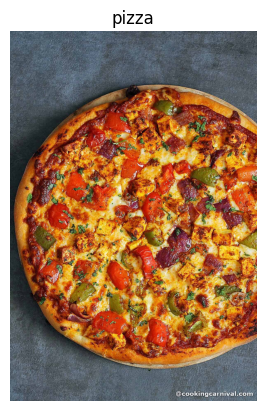

<Figure size 640x480 with 0 Axes>

In [43]:
print(pred_and_plot('Paneer-Pizza.jpg', model_5))

## Multi-Class Image Classification

1. Preprocess the data
2. Create a model (Start with the basiline)
3. Fit the model
4. Evaluate the model
5. Adjust different hyperparameters and improve the model

**Importing our data**

In [44]:
import zipfile

!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip

zip_ref = zipfile.ZipFile('10_food_classes_all_data.zip')
zip_ref.extractall()
zip_ref.close()

--2024-04-28 06:51:53--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.137.207, 142.250.101.207, 142.251.2.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.137.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 519183241 (495M) [application/zip]
Saving to: ‘10_food_classes_all_data.zip’

10_food_classes_all 100%[===================>] 495.13M   119MB/s    in 4.1s    

2024-04-28 06:51:57 (119 MB/s) - ‘10_food_classes_all_data.zip’ saved [519183241/519183241]



In [45]:
## Setup the train and test directory
train_dir = '/content/10_food_classes_all_data/train'
test_dir = '/content/10_food_classes_all_data/test'

In [46]:
## Getting the class names
import pathlib
import numpy as np

data_dir = pathlib.Path(train_dir)
class_names = np.array(sorted([item.name for item in data_dir.glob('*')]))
class_names

array(['chicken_curry', 'chicken_wings', 'fried_rice', 'grilled_salmon',
       'hamburger', 'ice_cream', 'pizza', 'ramen', 'steak', 'sushi'],
      dtype='<U14')

> ['3800701.jpg']
Image shape: (512, 512, 3)


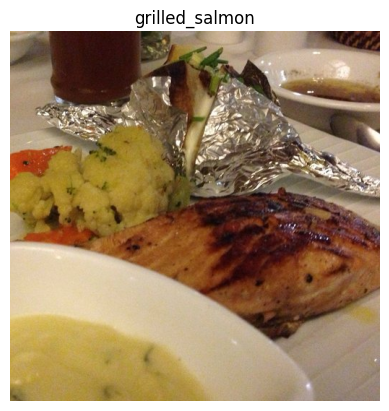

In [47]:
## Visualizing randomly
import random
img = view_rand_images(target_dir = train_dir, target_class=random.choice(class_names))

### 1.Preprocess the data

In [48]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

## Rescale
training_datagen = ImageDataGenerator(rescale=1/255.)
testing_datagen = ImageDataGenerator(rescale=1/255.)

## turning to batches
training_data = training_datagen.flow_from_directory(directory=train_dir,
                                                     target_size=(224, 224),
                                                     class_mode='categorical',
                                                     batch_size=32,
                                                     seed=42,
                                                     shuffle=True)

testing_data = training_datagen.flow_from_directory(directory=test_dir,
                                                    target_size=(224, 224),
                                                    class_mode='categorical',
                                                    seed=42)

Found 7500 images belonging to 10 classes.
Found 2500 images belonging to 10 classes.


### 2.Building the model and 3. Fit the model

In [49]:
tf.random.set_seed(42)

model_6 = Sequential([
    Conv2D(filters=10,
           kernel_size=3,
           activation='relu',
           input_shape=(224, 224, 3)),
    MaxPool2D(pool_size=2),

    Conv2D(10, 3, activation='relu'),
    MaxPool2D(pool_size=2),

    Conv2D(10, 3, activation='relu'),
    MaxPool2D(pool_size=2),

    Flatten(),
    Dense(10, activation='softmax') ## for multiclass classification
])

model_6.compile(
    loss = 'categorical_crossentropy',
    optimizer = Adam(),
    metrics = ['accuracy']
)

history_6 = model_6.fit(training_data,
                        epochs=5,
                        steps_per_epoch=len(training_data),
                        validation_data=testing_data,
                        validation_steps=len(testing_data))

Epoch 1/5
235/235 [==============================] - 30s 121ms/step - loss: 2.1800 - accuracy: 0.2023 - val_loss: 2.0239 - val_accuracy: 0.2876
Epoch 2/5
235/235 [==============================] - 28s 117ms/step - loss: 1.9391 - accuracy: 0.3225 - val_loss: 1.9140 - val_accuracy: 0.3184
Epoch 3/5
235/235 [==============================] - 28s 119ms/step - loss: 1.7645 - accuracy: 0.4000 - val_loss: 1.9060 - val_accuracy: 0.3316
Epoch 4/5
235/235 [==============================] - 30s 126ms/step - loss: 1.5408 - accuracy: 0.4824 - val_loss: 1.8790 - val_accuracy: 0.3592
Epoch 5/5
235/235 [==============================] - 28s 121ms/step - loss: 1.3113 - accuracy: 0.5596 - val_loss: 1.9179 - val_accuracy: 0.3528


### 4. Evaluating the model

In [50]:
model_6.evaluate(testing_data)

79/79 [==============================] - 6s 81ms/step - loss: 1.9179 - accuracy: 0.3528


[1.9178987741470337, 0.35280001163482666]

In [51]:
model_6.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_16 (Conv2D)          (None, 222, 222, 10)      280       
                                                                 
 max_pooling2d_11 (MaxPooli  (None, 111, 111, 10)      0         
 ng2D)                                                           
                                                                 
 conv2d_17 (Conv2D)          (None, 109, 109, 10)      910       
                                                                 
 max_pooling2d_12 (MaxPooli  (None, 54, 54, 10)        0         
 ng2D)                                                           
                                                                 
 conv2d_18 (Conv2D)          (None, 52, 52, 10)        910       
                                                                 
 max_pooling2d_13 (MaxPooli  (None, 26, 26, 10)       

<Axes: >

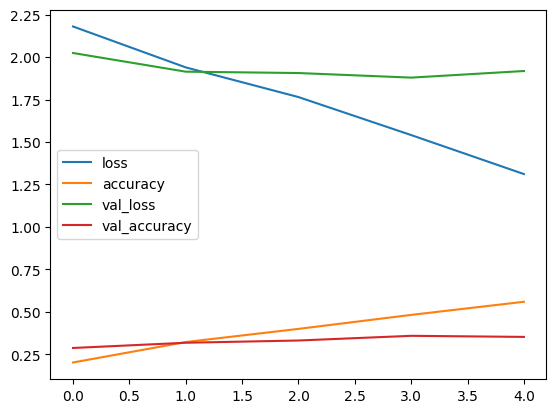

In [52]:
pd.DataFrame(history_6.history).plot()

### 4.Adjust the model hyperparameters (to beat the baseline / reduce overfitting).
* **Data Augmentation.**
* **Reduce number of nodes.**
* **Trasfer learning.** (coming up)

In [53]:
## Simplifying the model
## try to remove two convolution layer

model_7 = Sequential([
    Conv2D(filters=10, kernel_size=3, activation='relu', input_shape=(224, 224, 3)),
    MaxPool2D(pool_size=2),

    Conv2D(10, 3, activation='relu'),
    MaxPool2D(pool_size=2),

    Flatten(),
    Dense(10, activation='softmax')
])

model_7.compile(
    loss='categorical_crossentropy',
    optimizer=Adam(),
    metrics=['accuracy']
)

history_7 = model_7.fit(training_data,
                        epochs=5,
                        steps_per_epoch=len(training_data),
                        validation_data=testing_data,
                        validation_steps=len(testing_data))

Epoch 1/5
235/235 [==============================] - 29s 121ms/step - loss: 2.2350 - accuracy: 0.1981 - val_loss: 2.0453 - val_accuracy: 0.2612
Epoch 2/5
235/235 [==============================] - 29s 122ms/step - loss: 1.8842 - accuracy: 0.3471 - val_loss: 1.9864 - val_accuracy: 0.3040
Epoch 3/5
235/235 [==============================] - 28s 118ms/step - loss: 1.4849 - accuracy: 0.5031 - val_loss: 2.0801 - val_accuracy: 0.3028
Epoch 4/5
235/235 [==============================] - 28s 120ms/step - loss: 0.9894 - accuracy: 0.6901 - val_loss: 2.4163 - val_accuracy: 0.2712
Epoch 5/5
235/235 [==============================] - 31s 133ms/step - loss: 0.5346 - accuracy: 0.8443 - val_loss: 3.0514 - val_accuracy: 0.2480


<Axes: >

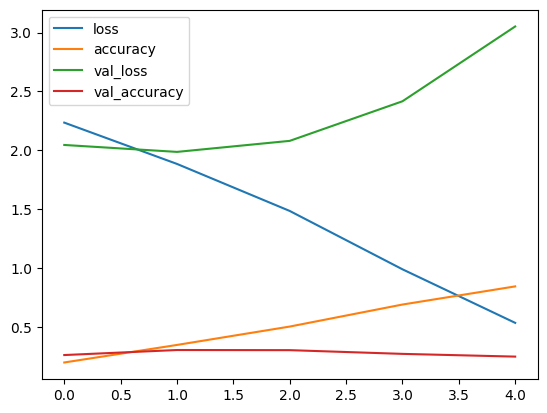

In [54]:
pd.DataFrame(history_7.history).plot()

In [55]:
model_7.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_19 (Conv2D)          (None, 222, 222, 10)      280       
                                                                 
 max_pooling2d_14 (MaxPooli  (None, 111, 111, 10)      0         
 ng2D)                                                           
                                                                 
 conv2d_20 (Conv2D)          (None, 109, 109, 10)      910       
                                                                 
 max_pooling2d_15 (MaxPooli  (None, 54, 54, 10)        0         
 ng2D)                                                           
                                                                 
 flatten_6 (Flatten)         (None, 29160)             0         
                                                                 
 dense_6 (Dense)             (None, 10)               

The lesser the total params the more will be accuracy

In this case the `model_6 got 69710 (272.30 KB)` but `the model_7 got 292800 (1.12 MB)`

Data Augmentation for better results

In [56]:
training_data_augmentation = ImageDataGenerator(rescale=1/255.,
                                                rotation_range=0.2,
                                                shear_range=0.2,
                                                zoom_range=0.2,
                                                horizontal_flip=True)
testing_datagen = ImageDataGenerator(rescale=1/255.)

In [57]:
training_data_augmented = training_data_augmentation.flow_from_directory(directory=train_dir,
                                                                            target_size=(224, 224),
                                                                            class_mode='categorical',
                                                                            batch_size=32,
                                                                            shuffle=True)

testing_data = testing_datagen.flow_from_directory(directory=test_dir,
                                                  target_size=(224, 224),
                                                  batch_size=32,
                                                  class_mode='categorical',
                                                  shuffle=True)

Found 7500 images belonging to 10 classes.
Found 2500 images belonging to 10 classes.


**Cloninig the Model_5**

In [58]:
## Cloninig the model_5

model_8 = tf.keras.models.clone_model(model_6)

model_8.compile(
    loss = 'categorical_crossentropy',
    optimizer = Adam(),
    metrics = ['accuracy']
)

In [59]:
history_8 = model_8.fit(training_data_augmented,
            epochs=5,
            steps_per_epoch=len(training_data_augmented),
            validation_data=testing_data,
            validation_steps=len(testing_data))

Epoch 1/5
235/235 [==============================] - 100s 421ms/step - loss: 2.1564 - accuracy: 0.2136 - val_loss: 1.9683 - val_accuracy: 0.2956
Epoch 2/5
235/235 [==============================] - 102s 432ms/step - loss: 1.9509 - accuracy: 0.3195 - val_loss: 1.8833 - val_accuracy: 0.3444
Epoch 3/5
235/235 [==============================] - 101s 429ms/step - loss: 1.8851 - accuracy: 0.3433 - val_loss: 1.8230 - val_accuracy: 0.3604
Epoch 4/5
235/235 [==============================] - 99s 422ms/step - loss: 1.8259 - accuracy: 0.3715 - val_loss: 1.8241 - val_accuracy: 0.3836
Epoch 5/5
235/235 [==============================] - 99s 419ms/step - loss: 1.7807 - accuracy: 0.3900 - val_loss: 1.7661 - val_accuracy: 0.3972


<Axes: >

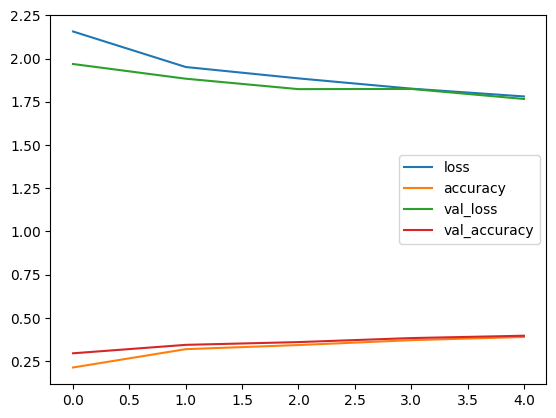

In [60]:
pd.DataFrame(history_8.history).plot()

In [62]:
model_8.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_16 (Conv2D)          (None, 222, 222, 10)      280       
                                                                 
 max_pooling2d_11 (MaxPooli  (None, 111, 111, 10)      0         
 ng2D)                                                           
                                                                 
 conv2d_17 (Conv2D)          (None, 109, 109, 10)      910       
                                                                 
 max_pooling2d_12 (MaxPooli  (None, 54, 54, 10)        0         
 ng2D)                                                           
                                                                 
 conv2d_18 (Conv2D)          (None, 52, 52, 10)        910       
                                                                 
 max_pooling2d_13 (MaxPooli  (None, 26, 26, 10)       

### Predicting on our own image

--2024-04-28 07:08:19--  https://myfoodstory.com/wp-content/uploads/2020/10/Dhaba-Style-Chicken-Curry-1.jpg
Resolving myfoodstory.com (myfoodstory.com)... 172.67.197.29, 104.21.92.186, 2606:4700:3037::ac43:c51d, ...
Connecting to myfoodstory.com (myfoodstory.com)|172.67.197.29|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 151494 (148K) [image/jpeg]
Saving to: ‘Dhaba-Style-Chicken-Curry-1.jpg.2’

Dhaba-Style-Chicken 100%[===================>] 147.94K  --.-KB/s    in 0.02s   

2024-04-28 07:08:19 (9.37 MB/s) - ‘Dhaba-Style-Chicken-Curry-1.jpg.2’ saved [151494/151494]



(-0.5, 1199.5, 1799.5, -0.5)

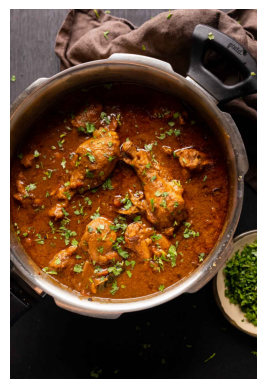

In [65]:
!wget https://myfoodstory.com/wp-content/uploads/2020/10/Dhaba-Style-Chicken-Curry-1.jpg

img = mping.imread('Dhaba-Style-Chicken-Curry-1.jpg')
plt.imshow(img)
plt.axis(False)

In [66]:
def pred_and_plot_multi(filename, Model, class_name=class_names):
  loaded_image = load_image_pre_image(filename)
  predict = Model.predict(tf.expand_dims(loaded_image, axis=0))
  image = mping.imread(filename)
  plt.imshow(image)
  plt.axis(False)

  if predict[0] > 1:
    plt.title(class_names[int(tf.round(predict))])
  else:
    plt.title(class_name[tf.argmax(predict[0], axis=0)])

  plt.figure()

In [91]:
file_name = 'Dhaba-Style-Chicken-Curry-1.jpg'
loaded_image = load_image_pre_image(file_name)
predict = model_8.predict(tf.expand_dims(loaded_image, axis=0))
predict

1/1 [==============================] - 0s 17ms/step


array([[0.14404692, 0.44537085, 0.08321948, 0.10462775, 0.06303802,
        0.00103537, 0.05654379, 0.0449502 , 0.02696251, 0.03020509]],
      dtype=float32)

In [92]:
predict = tf.argmax(tf.squeeze(predict)).numpy()
predict

1

(-0.5, 1199.5, 1799.5, -0.5)

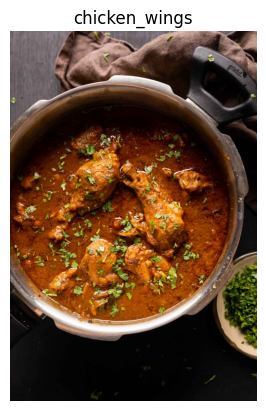

In [95]:
plt.imshow(img)
plt.title(class_names[predict])
plt.axis(False)